In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import kornia
from models.P2CNet import P2CNet
from models.CLUIE_Net import UNetEncoder, UNetDecoder
from datasets.dataloader import TestDataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image


def to_img(x,high,width):
    """Convert the tanh (-1 to 1) ranged tensor to image (0 to 1) tensor"""
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, high, width)
    return x

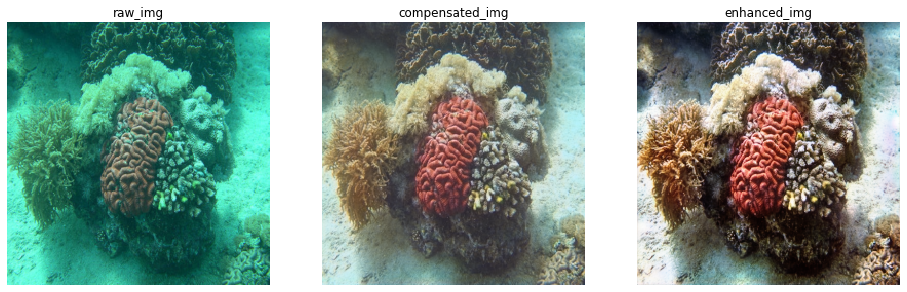

In [4]:
# load compensation model(P2CNet) and enhancement model(CLUIE-Net)
P2CNet = P2CNet().cuda()
P2CNet.load_state_dict(torch.load('./ckpt/P2C/P2CNet.pth'))
P2CNet.eval()

CLUIE_encoder = UNetEncoder().cuda()
CLUIE_decoder = UNetDecoder().cuda()
CLUIE_encoder.load_state_dict(torch.load('./ckpt/CLUIE/fE_latest.pth'))
CLUIE_decoder.load_state_dict(torch.load('./ckpt/CLUIE/fI_latest.pth'))
CLUIE_encoder.eval()
CLUIE_decoder.eval()

with torch.no_grad():
    # read raw image
    raw_img = cv2.imread('./samples/13.png')
    raw_img = cv2.resize(raw_img, (256, 256))
    rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (16, 30))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("raw_img")
    plt.imshow(rgb)
    rgb = torch.tensor(rgb.astype(float).transpose(2, 0, 1), dtype=torch.float) / 255.  
    lab = kornia.color.rgb_to_lab(rgb)
    l = lab[:1, :, :] / 100.
    ab = lab[1:, :, :] / 127.
    lab = torch.cat([l, ab], dim=0).unsqueeze(0)
    compensate_input = lab.cuda()
    # stage1: color compensation
    compensate_out = P2CNet(compensate_input)['lab_rgb']
    mid_out = compensate_out.to(device="cpu").numpy().squeeze()
    mid_out = np.clip(mid_out * 255.0, 0, 255)
    compensated_img = Image.fromarray(np.uint8(mid_out).transpose(1, 2, 0))
    compensated_img.save(os.path.join('./samples/compensated_img.png'))
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title("compensated_img")
    plt.imshow(compensated_img)
    # stage2: Enhancement
    fE_out, enc_outs = CLUIE_encoder(compensate_out)
    enhance_out = to_img(CLUIE_decoder(fE_out, enc_outs), compensate_out.shape[2], compensate_out.shape[3])
    enhance_out = enhance_out.to(device="cpu").numpy().squeeze()
    enhance_out = np.clip(enhance_out * 255.0, 0, 255)
    enhanced_img = Image.fromarray(np.uint8(enhance_out).transpose(1, 2, 0))
    enhanced_img.save(os.path.join('./samples/enhanced_img.png'))
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title("enhanced_img")
    plt.imshow(enhanced_img)
    plt.show()